# Experiment Design

this is the original experiment design problem showing B-optimal doesn't necessarily work

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Problem data
m = 10
angles1 = np.linspace(3*np.pi/4, np.pi, m)
angles2 = np.linspace(0, -np.pi/2, m)

# Sensor positions
V = np.hstack((3.0 * np.array([np.cos(angles1), np.sin(angles1)]), 
               1.5 * np.array([np.cos(angles2), np.sin(angles2)])))
p = V.shape[1]
n = 2
noangles = 5000

############################################
# D-optimal design
############################################
lambda_d = cp.Variable(p)
objective = cp.Maximize(cp.log_det(V @ cp.diag(lambda_d) @ V.T))
constraints = [cp.sum(lambda_d) == 1, lambda_d >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()

lambda_d_value = lambda_d.value


############################################
# A-optimal design
############################################
lambda_a = cp.Variable(p)
u = cp.Variable(n)
objective = cp.Minimize(cp.sum(u))
constraints = []
for k in range(n):
    M = cp.vstack([
        cp.hstack([V @ cp.diag(lambda_a) @ V.T, np.eye(n)[:, k:k+1]]),
        cp.hstack([np.eye(n)[k:k+1, :], cp.reshape(u[k], (1, 1))])
    ])
    constraints.append(M >> 0)
constraints += [cp.sum(lambda_a) == 1, lambda_a >= 0]

problem = cp.Problem(objective, constraints)
problem.solve()

lambda_a_value = lambda_a.value

############################################
# E-optimal design
############################################
t = cp.Variable()
lambda_e = cp.Variable(p)
objective = cp.Maximize(t)
constraints = [V @ cp.diag(lambda_e) @ V.T >> t * np.eye(n)]
constraints += [cp.sum(lambda_e) == 1, lambda_e >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()

lambda_e_value = lambda_e.value

############################################
# B-optimal design
############################################
lambda_b = cp.Variable(p)
objective = cp.Maximize(cp.trace(V @ cp.diag(lambda_b) @ V.T))
constraints = [cp.sum(lambda_b) == 1, lambda_b >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()

lambda_b_value = lambda_b.value


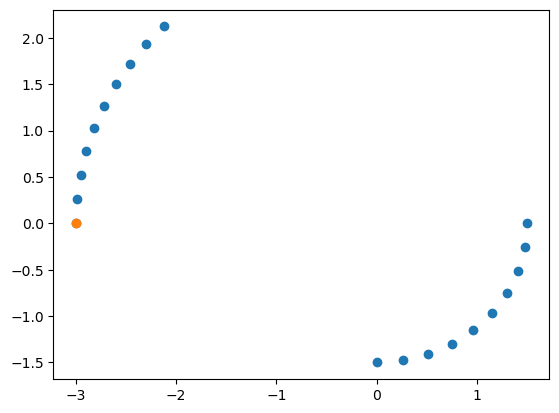

In [2]:
# find indices of lambda_b_value > 0.001
np.where(lambda_b_value > 0.001)
plt.scatter(V[0,:], V[1,:])
plt.scatter(V[0, lambda_b_value > 0.001], V[1, lambda_b_value > 0.001])

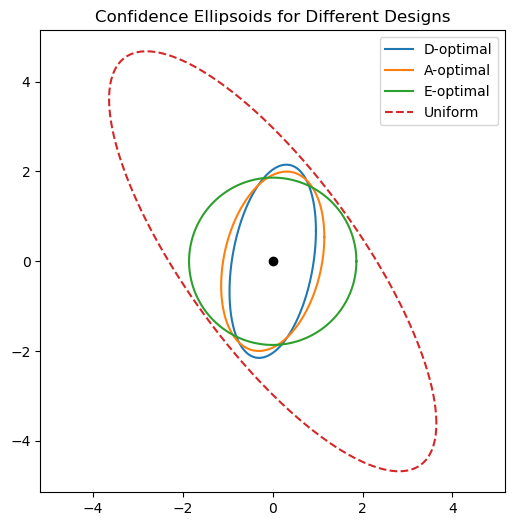

In [3]:
# Confidence ellipsoids for all designs
eta = 6.2514  # chi2inv(.9,3)
angles = np.linspace(0, 2 * np.pi, noangles)
plt.figure(figsize=(6, 6))

# D-optimal ellipsoid
W = V @ np.diag(lambda_d_value) @ V.T
R = np.linalg.cholesky(W)
ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='D-optimal')

# A-optimal ellipsoid
W = V @ np.diag(lambda_a_value) @ V.T
R = np.linalg.cholesky(W)
ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='A-optimal')

# E-optimal ellipsoid
W = V @ np.diag(lambda_e_value) @ V.T
R = np.linalg.cholesky(W)
ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='E-optimal')

# B-optimal ellipsoid
W = V @ np.diag(lambda_b.value) @ V.T
# check if W is positive definite
if np.all(np.linalg.eigvals(W) >= 0):
    R = np.linalg.cholesky(W)
    ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='B-optimal')

# Uniform design ellipsoid
W_u = np.linalg.inv(V @ V.T / p)
R = np.linalg.cholesky(W_u)
ellipsoid_u = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid_u[0, :], ellipsoid_u[1, :], '--', label='Uniform')

plt.scatter(0, 0, color='black')
plt.axis('equal')
plt.legend()
plt.title('Confidence Ellipsoids for Different Designs')
plt.show()

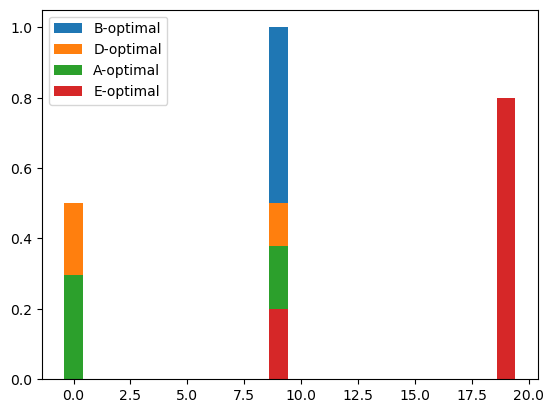

In [4]:
plt.bar(range(p), lambda_b.value, label='B-optimal')
plt.bar(range(p), lambda_d_value, label='D-optimal')
plt.bar(range(p), lambda_a_value, label='A-optimal')
plt.bar(range(p), lambda_e_value, label='E-optimal')
plt.legend()


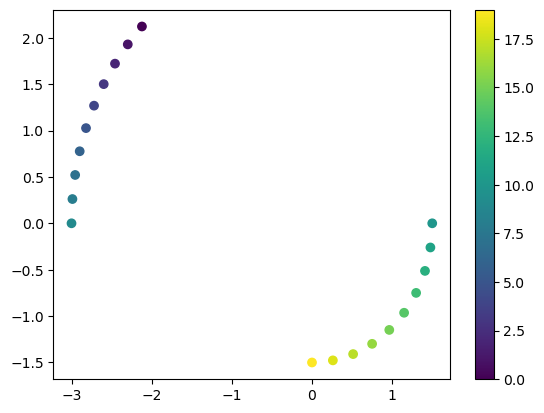

In [5]:
# scatter V points with label 1:p 
plt.scatter(V[0, :], V[1, :], c=range(p))
plt.colorbar()

# Solving the Dual Problem

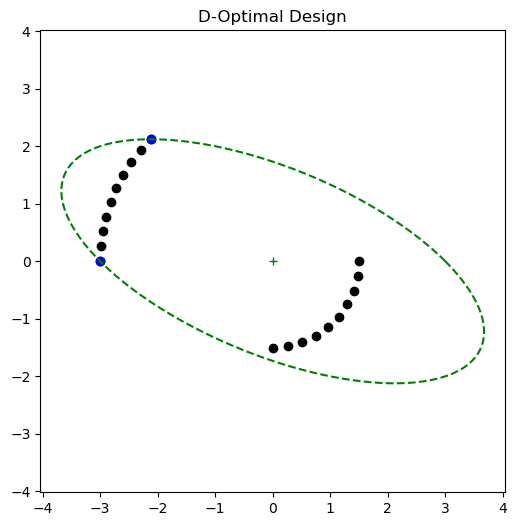

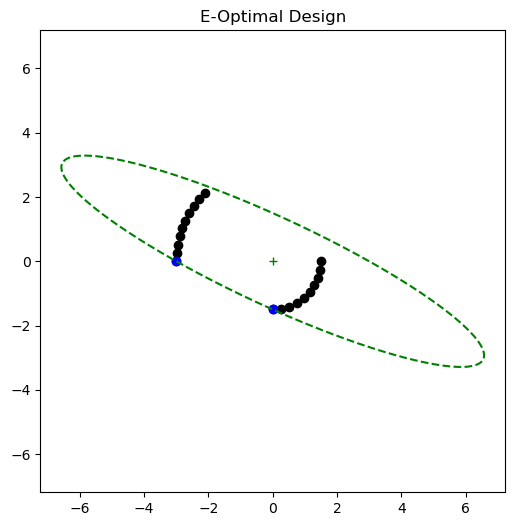

In [6]:
# D-optimal design (dual problem)
W = cp.Variable((n, n), symmetric=True)
objective = cp.Maximize(cp.log_det(W) + n * cp.log(2))
constraints = [cp.quad_form(V[:, i], W) <= 1 for i in range(p)] + [W >> 0]
problem = cp.Problem(objective, constraints)
problem.solve()

W_value = W.value
# Plot D-optimal design results
plt.figure(figsize=(6, 6))
angles = np.linspace(0, 2 * np.pi, noangles)
R = np.linalg.cholesky(W_value).T
ellipsoid = np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], '--', color=[0, 0.5, 0])
plt.plot(0, 0, '+', color=[0, 0.5, 0], markerfacecolor=[0, 0.5, 0])
plt.scatter(V[0, :], V[1, :], color='black')
plt.scatter(V[0, lambda_d_value > 0.001], V[1, lambda_d_value > 0.001], color='blue')
plt.axis('equal')
plt.title('D-Optimal Design')
plt.show()

# # A-optimal design (dual problem)
# W = cp.Variable((n, n), symmetric=True)
# # objective = cp.Maximize(cp.lambda_min(W))
# objective = cp.Maximize(cp.square(cp.trace(cp.sqrt(W))))
# constraints = [cp.quad_form(V[:, i], W) <= 1 for i in range(p)] + [W >= 0]
# problem = cp.Problem(objective, constraints)
# problem.solve(qcp=True, verbose=True)

# W_value = W.value
# # Plot A-optimal design results
# plt.figure(figsize=(6, 6))
# angles = np.linspace(0, 2 * np.pi, noangles)
# R = np.linalg.cholesky(W_value).T
# ellipsoid = np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
# plt.plot(ellipsoid[0, :], ellipsoid[1, :], '--', color=[0, 0.5, 0])
# plt.plot(0, 0, '+', color=[0, 0.5, 0], markerfacecolor=[0, 0.5, 0])
# plt.scatter(V[0, :], V[1, :], color='black')
# plt.scatter(V[0, lambda_a_value > 0.001], V[1, lambda_a_value > 0.001], color='blue')
# plt.axis('equal')
# plt.title('A-Optimal Design')
# plt.show()

# E-optimal design (dual problem)
W = cp.Variable((n, n), symmetric=True)
objective = cp.Maximize(cp.trace(W))
constraints = [cp.quad_form(V[:, i], W) <= 1 for i in range(p)]
constraints += [W >> 0]
problem = cp.Problem(objective, constraints)
problem.solve()

W_value = W.value
# Plot E-optimal design results
plt.figure(figsize=(6, 6))
angles = np.linspace(0, 2 * np.pi, noangles)
R = np.linalg.cholesky(W_value).T
ellipsoid = np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], '--', color=[0, 0.5, 0])
plt.plot(0, 0, '+', color=[0, 0.5, 0], markerfacecolor=[0, 0.5, 0])
plt.scatter(V[0, :], V[1, :], color='black')
plt.scatter(V[0, lambda_e_value > 0.001], V[1, lambda_e_value > 0.001], color='blue')
plt.axis('equal')
plt.title('E-Optimal Design')
plt.show()


# Priors and Previously Collected Data

this is the case where we have already sampled some points

TODO: include priors and visualize how that impacts the solution

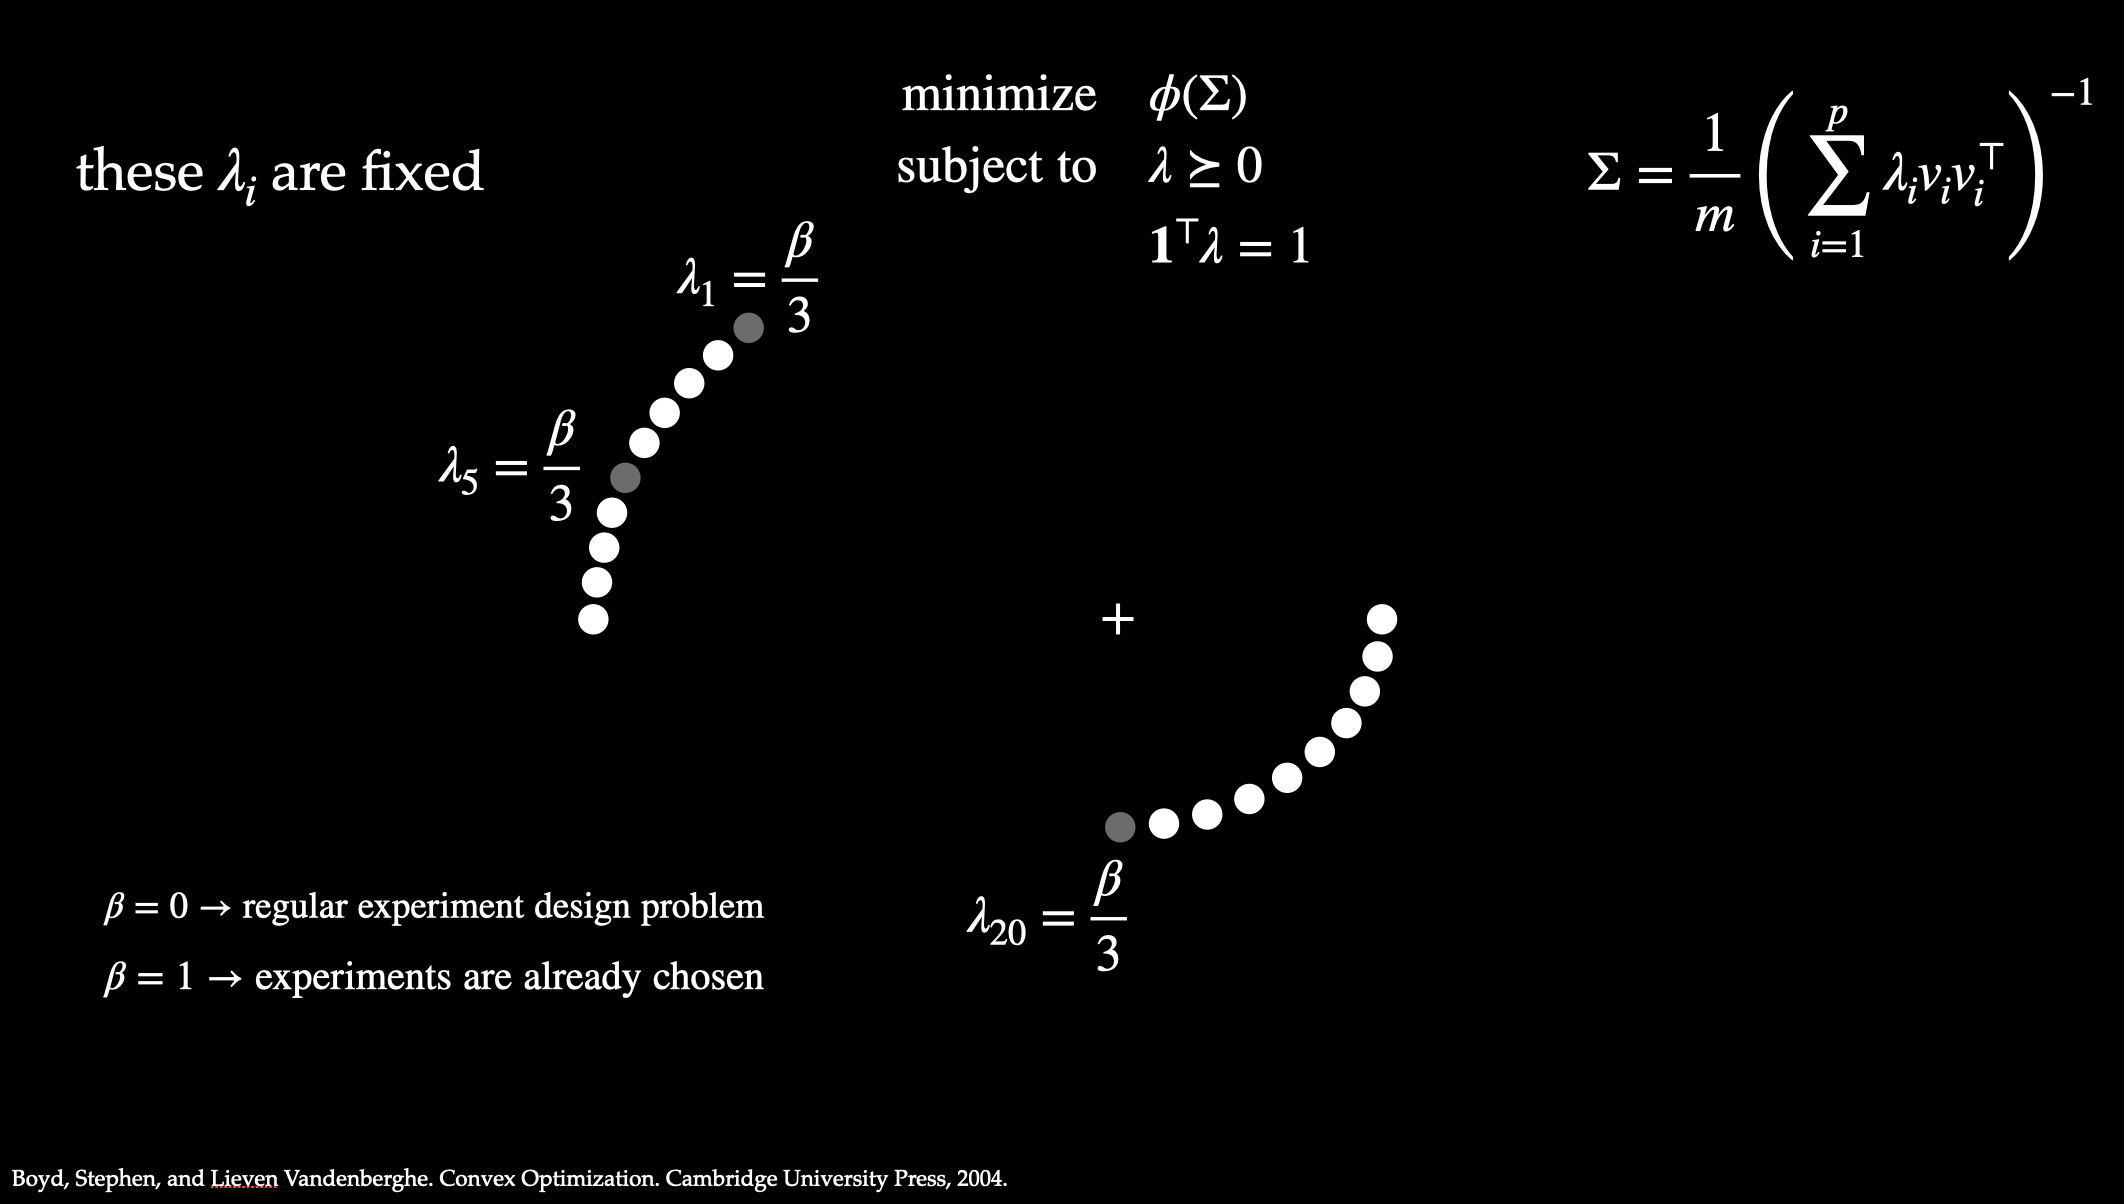

In [9]:
# include image.png 
from PIL import Image
img = Image.open('image.png')
img

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Problem data
m = 10
angles1 = np.linspace(3*np.pi/4, np.pi, m)
angles2 = np.linspace(0, -np.pi/2, m)

# Sensor positions
V = np.hstack((3.0 * np.array([np.cos(angles1), np.sin(angles1)]), 
               1.5 * np.array([np.cos(angles2), np.sin(angles2)])))
p = V.shape[1]
n = 2
noangles = 5000

############################################
# D-optimal design
############################################
lambda_d = cp.Variable(p)
objective = cp.Maximize(cp.log_det(V @ cp.diag(lambda_d) @ V.T))
constraints = [cp.sum(lambda_d) == 2, lambda_d >= 0]
constraints += [lambda_d[4] == 1]
problem = cp.Problem(objective, constraints)
problem.solve()

lambda_d_value = lambda_d.value


############################################
# A-optimal design
############################################
lambda_a = cp.Variable(p)
u = cp.Variable(n)
objective = cp.Minimize(cp.sum(u))
constraints = []
for k in range(n):
    M = cp.vstack([
        cp.hstack([V @ cp.diag(lambda_a) @ V.T, np.eye(n)[:, k:k+1]]),
        cp.hstack([np.eye(n)[k:k+1, :], cp.reshape(u[k], (1, 1))])
    ])
    constraints.append(M >> 0)
constraints += [cp.sum(lambda_a) == 2, lambda_a >= 0]
constraints += [lambda_a[4] == 1]

problem = cp.Problem(objective, constraints)
problem.solve()

lambda_a_value = lambda_a.value

############################################
# E-optimal design
############################################
t = cp.Variable()
lambda_e = cp.Variable(p)
objective = cp.Maximize(t)
constraints = [V @ cp.diag(lambda_e) @ V.T >> t * np.eye(n)]
constraints += [cp.sum(lambda_e) == 2, lambda_e >= 0]
constraints += [lambda_e[4] == 1]
problem = cp.Problem(objective, constraints)
problem.solve()

lambda_e_value = lambda_e.value

############################################
# B-optimal design
############################################
lambda_b = cp.Variable(p)
objective = cp.Maximize(cp.trace(V @ cp.diag(lambda_b) @ V.T))
constraints = [cp.sum(lambda_b) == 2, lambda_b >= 0]
constraints += [lambda_b[4] == 1]
problem = cp.Problem(objective, constraints)
problem.solve()


18.0

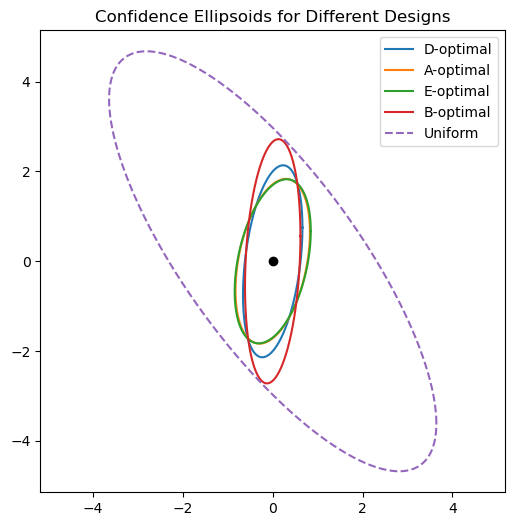

In [33]:
# Confidence ellipsoids for all designs
eta = 6.2514  # chi2inv(.9,3)
angles = np.linspace(0, 2 * np.pi, noangles)
plt.figure(figsize=(6, 6))

# D-optimal ellipsoid
W = V @ np.diag(lambda_d_value) @ V.T
R = np.linalg.cholesky(W)
ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='D-optimal')

# A-optimal ellipsoid
W = V @ np.diag(lambda_a_value) @ V.T
R = np.linalg.cholesky(W)
ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='A-optimal')

# E-optimal ellipsoid
W = V @ np.diag(lambda_e_value) @ V.T
R = np.linalg.cholesky(W)
ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='E-optimal')

# B-optimal ellipsoid
W = V @ np.diag(lambda_b.value) @ V.T
# check if W is positive definite
if np.all(np.linalg.eigvals(W) >= 0):
    R = np.linalg.cholesky(W)
    ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='B-optimal')

# Uniform design ellipsoid
W_u = np.linalg.inv(V @ V.T / p)
R = np.linalg.cholesky(W_u)
ellipsoid_u = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid_u[0, :], ellipsoid_u[1, :], '--', label='Uniform')

plt.scatter(0, 0, color='black')
plt.axis('equal')
plt.legend()
plt.title('Confidence Ellipsoids for Different Designs')
plt.show()

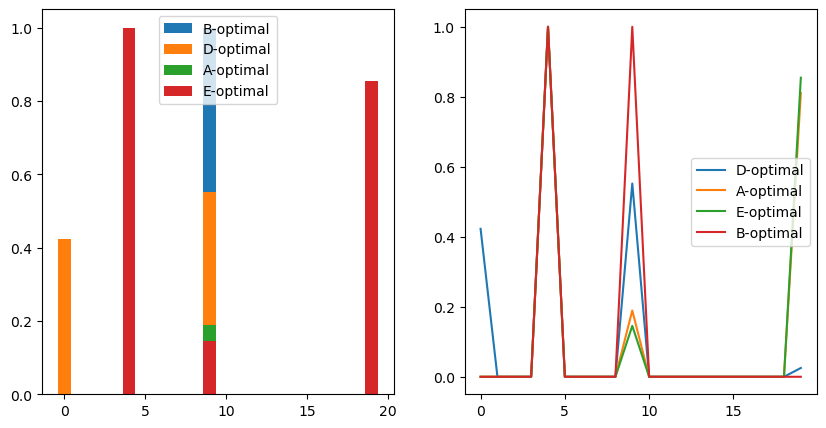

In [32]:
# create 1 by 2 subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# first subplot
axs[0].bar(range(p), lambda_b.value, label='B-optimal')
axs[0].bar(range(p), lambda_d_value, label='D-optimal')
axs[0].bar(range(p), lambda_a_value, label='A-optimal')
axs[0].bar(range(p), lambda_e_value, label='E-optimal')
axs[0].legend()

# second subplot
axs[1].plot(lambda_d_value, label='D-optimal')
axs[1].plot(lambda_a_value, label='A-optimal')
axs[1].plot(lambda_e_value, label='E-optimal')
axs[1].plot(lambda_b.value, label='B-optimal')
axs[1].legend()



alternate formulation where we preselect multiple indices 

In [49]:
num_pre_selected = np.random.randint(1, p)

np.random.choice(p, num_pre_selected, replace=False)
np.random.randint(1, 5, num_pre_selected) / sum()

array([3, 3, 1])

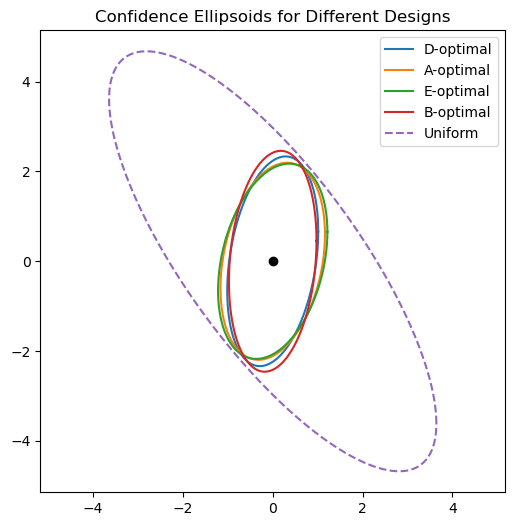

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Problem data
m = 10
angles1 = np.linspace(3*np.pi/4, np.pi, m)
angles2 = np.linspace(0, -np.pi/2, m)

# Sensor positions
V = np.hstack((3.0 * np.array([np.cos(angles1), np.sin(angles1)]), 
               1.5 * np.array([np.cos(angles2), np.sin(angles2)])))
p = V.shape[1]
n = 2
noangles = 5000

# Pre-selected points
pre_selected_indices = [0, 5, 19]  # indices of the pre-selected points
slider_val = 0.5
pre_selected_counts = [slider_val/3, slider_val/3, slider_val/3]  # corresponding fixed lambda values
pre_selected_sum = sum(pre_selected_counts)

############################################
# D-optimal design
############################################
lambda_d = cp.Variable(p)
objective = cp.Maximize(cp.log_det(V @ cp.diag(lambda_d) @ V.T))
constraints = [cp.sum(lambda_d) == 1, lambda_d >= 0]
for i, idx in enumerate(pre_selected_indices):
    constraints.append(lambda_d[idx] == pre_selected_counts[i])
problem = cp.Problem(objective, constraints)
problem.solve()

lambda_d_value = lambda_d.value

############################################
# A-optimal design
############################################
lambda_a = cp.Variable(p)
u = cp.Variable(n)
objective = cp.Minimize(cp.sum(u))
constraints = []
for k in range(n):
    M = cp.vstack([
        cp.hstack([V @ cp.diag(lambda_a) @ V.T, np.eye(n)[:, k:k+1]]),
        cp.hstack([np.eye(n)[k:k+1, :], cp.reshape(u[k], (1, 1))])
    ])
    constraints.append(M >> 0)
constraints += [cp.sum(lambda_a) == 1, lambda_a >= 0]
for i, idx in enumerate(pre_selected_indices):
    constraints.append(lambda_a[idx] == pre_selected_counts[i])

problem = cp.Problem(objective, constraints)
problem.solve()

lambda_a_value = lambda_a.value

############################################
# E-optimal design
############################################
t = cp.Variable()
lambda_e = cp.Variable(p)
objective = cp.Maximize(t)
constraints = [V @ cp.diag(lambda_e) @ V.T >> t * np.eye(n)]
constraints += [cp.sum(lambda_e) == 1, lambda_e >= 0]
for i, idx in enumerate(pre_selected_indices):
    constraints.append(lambda_e[idx] == pre_selected_counts[i])

problem = cp.Problem(objective, constraints)
problem.solve()

lambda_e_value = lambda_e.value

############################################
# B-optimal design
############################################
lambda_b = cp.Variable(p)
objective = cp.Maximize(cp.trace(V @ cp.diag(lambda_b) @ V.T))
constraints = [cp.sum(lambda_b) == 1, lambda_b >= 0]
for i, idx in enumerate(pre_selected_indices):
    constraints.append(lambda_b[idx] == pre_selected_counts[i])

problem = cp.Problem(objective, constraints)
problem.solve()

lambda_b_value = lambda_b.value

# Confidence ellipsoids for all designs
eta = 6.2514  # chi2inv(.9,3)
angles = np.linspace(0, 2 * np.pi, noangles)
plt.figure(figsize=(6, 6))

# D-optimal ellipsoid
W = V @ np.diag(lambda_d_value) @ V.T
R = np.linalg.cholesky(W)
ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='D-optimal')

# A-optimal ellipsoid
W = V @ np.diag(lambda_a_value) @ V.T
R = np.linalg.cholesky(W)
ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='A-optimal')

# E-optimal ellipsoid
W = V @ np.diag(lambda_e_value) @ V.T
R = np.linalg.cholesky(W)
ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='E-optimal')

# B-optimal ellipsoid
W = V @ np.diag(lambda_b_value) @ V.T
# check if W is positive definite
if np.all(np.linalg.eigvals(W) >= 0):
    R = np.linalg.cholesky(W)
    ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='B-optimal')

# Uniform design ellipsoid
W_u = np.linalg.inv(V @ V.T / p)
R = np.linalg.cholesky(W_u)
ellipsoid_u = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
plt.plot(ellipsoid_u[0, :], ellipsoid_u[1, :], '--', label='Uniform')

plt.scatter(0, 0, color='black')
plt.axis('equal')
plt.legend()
plt.title('Confidence Ellipsoids for Different Designs')
plt.show()


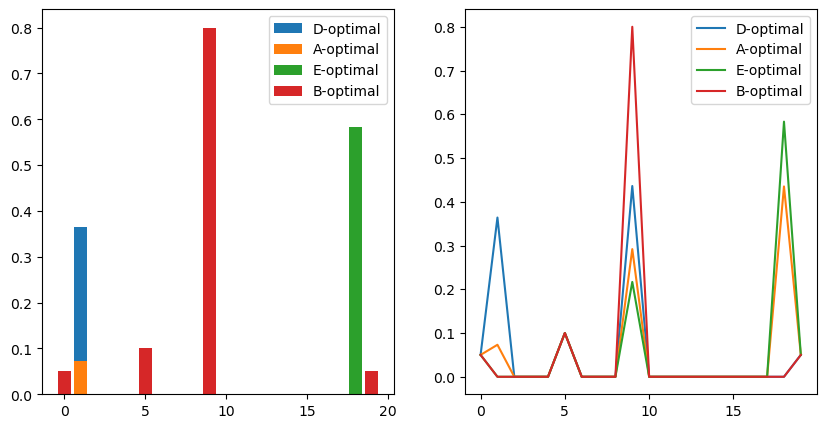

In [51]:
# create 1 by 2 subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# first subplot
axs[0].bar(range(p), lambda_d.value, label='D-optimal')
axs[0].bar(range(p), lambda_a_value, label='A-optimal')
axs[0].bar(range(p), lambda_e_value, label='E-optimal')
axs[0].bar(range(p), lambda_b.value, label='B-optimal')
axs[0].legend()

# second subplot
axs[1].plot(lambda_d_value, label='D-optimal')
axs[1].plot(lambda_a_value, label='A-optimal')
axs[1].plot(lambda_e_value, label='E-optimal')
axs[1].plot(lambda_b.value, label='B-optimal')
axs[1].legend()



# Slider Viz

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import ipywidgets as widgets
from IPython.display import display

# Problem data
m = 10
angles1 = np.linspace(3*np.pi/4, np.pi, m)
angles2 = np.linspace(0, -np.pi/2, m)

# Sensor positions
V = np.hstack((3.0 * np.array([np.cos(angles1), np.sin(angles1)]), 
               1.5 * np.array([np.cos(angles2), np.sin(angles2)])))
p = V.shape[1]
n = 2
noangles = 5000

# Pre-selected points
pre_selected_indices = [0, 5, 19]  # indices of the pre-selected points

def update_plot(slider_val):
    pre_selected_counts = [slider_val/3, slider_val/3, slider_val/3]  # corresponding fixed lambda values
    pre_selected_sum = sum(pre_selected_counts)

    ############################################
    # D-optimal design
    ############################################
    lambda_d = cp.Variable(p)
    objective = cp.Maximize(cp.log_det(V @ cp.diag(lambda_d) @ V.T))
    constraints = [cp.sum(lambda_d) == 1, lambda_d >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_d[idx] == pre_selected_counts[i])
    problem = cp.Problem(objective, constraints)
    problem.solve()

    lambda_d_value = lambda_d.value

    ############################################
    # A-optimal design
    ############################################
    lambda_a = cp.Variable(p)
    u = cp.Variable(n)
    objective = cp.Minimize(cp.sum(u))
    constraints = []
    for k in range(n):
        M = cp.vstack([
            cp.hstack([V @ cp.diag(lambda_a) @ V.T, np.eye(n)[:, k:k+1]]),
            cp.hstack([np.eye(n)[k:k+1, :], cp.reshape(u[k], (1, 1))])
        ])
        constraints.append(M >> 0)
    constraints += [cp.sum(lambda_a) == 1, lambda_a >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_a[idx] == pre_selected_counts[i])

    problem = cp.Problem(objective, constraints)
    problem.solve()

    lambda_a_value = lambda_a.value

    ############################################
    # E-optimal design
    ############################################
    t = cp.Variable()
    lambda_e = cp.Variable(p)
    objective = cp.Maximize(t)
    constraints = [V @ cp.diag(lambda_e) @ V.T >> t * np.eye(n)]
    constraints += [cp.sum(lambda_e) == 1, lambda_e >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_e[idx] == pre_selected_counts[i])

    problem = cp.Problem(objective, constraints)
    problem.solve()

    lambda_e_value = lambda_e.value

    ############################################
    # B-optimal design
    ############################################
    lambda_b = cp.Variable(p)
    objective = cp.Maximize(cp.trace(V @ cp.diag(lambda_b) @ V.T))
    constraints = [cp.sum(lambda_b) == 1, lambda_b >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_b[idx] == pre_selected_counts[i])

    problem = cp.Problem(objective, constraints)
    problem.solve()

    lambda_b_value = lambda_b.value

    # Confidence ellipsoids for all designs
    eta = 6.2514  # chi2inv(.9,3)
    angles = np.linspace(0, 2 * np.pi, noangles)
    plt.figure(figsize=(6, 6))

    # D-optimal ellipsoid
    W = V @ np.diag(lambda_d_value) @ V.T
    R = np.linalg.cholesky(W)
    ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='D-optimal')

    # A-optimal ellipsoid
    W = V @ np.diag(lambda_a_value) @ V.T
    R = np.linalg.cholesky(W)
    ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='A-optimal')

    # E-optimal ellipsoid
    W = V @ np.diag(lambda_e_value) @ V.T
    R = np.linalg.cholesky(W)
    ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='E-optimal')

    # B-optimal ellipsoid
    W = V @ np.diag(lambda_b_value) @ V.T
    # check if W is positive definite
    if np.all(np.linalg.eigvals(W) >= 0):
        R = np.linalg.cholesky(W)
        ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
        plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='B-optimal')

    # Uniform design ellipsoid
    W_u = np.linalg.inv(V @ V.T / p)
    R = np.linalg.cholesky(W_u)
    ellipsoid_u = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid_u[0, :], ellipsoid_u[1, :], '--', label='Uniform')

    plt.scatter(0, 0, color='black')
    plt.axis('equal')
    plt.legend()
    plt.title('Confidence Ellipsoids for Different Designs')
    plt.show()

# Create the interactive slider
slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Slider:')
widgets.interactive(update_plot, slider_val=slider)

# Display the slider
display(slider)

# Initial plot
update_plot(0.5)


# GIF

/var/folders/gq/j5vwgp6n61vgbjxq5yr427w40000gn/T/ipykernel_12830/1966259539.py:192: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


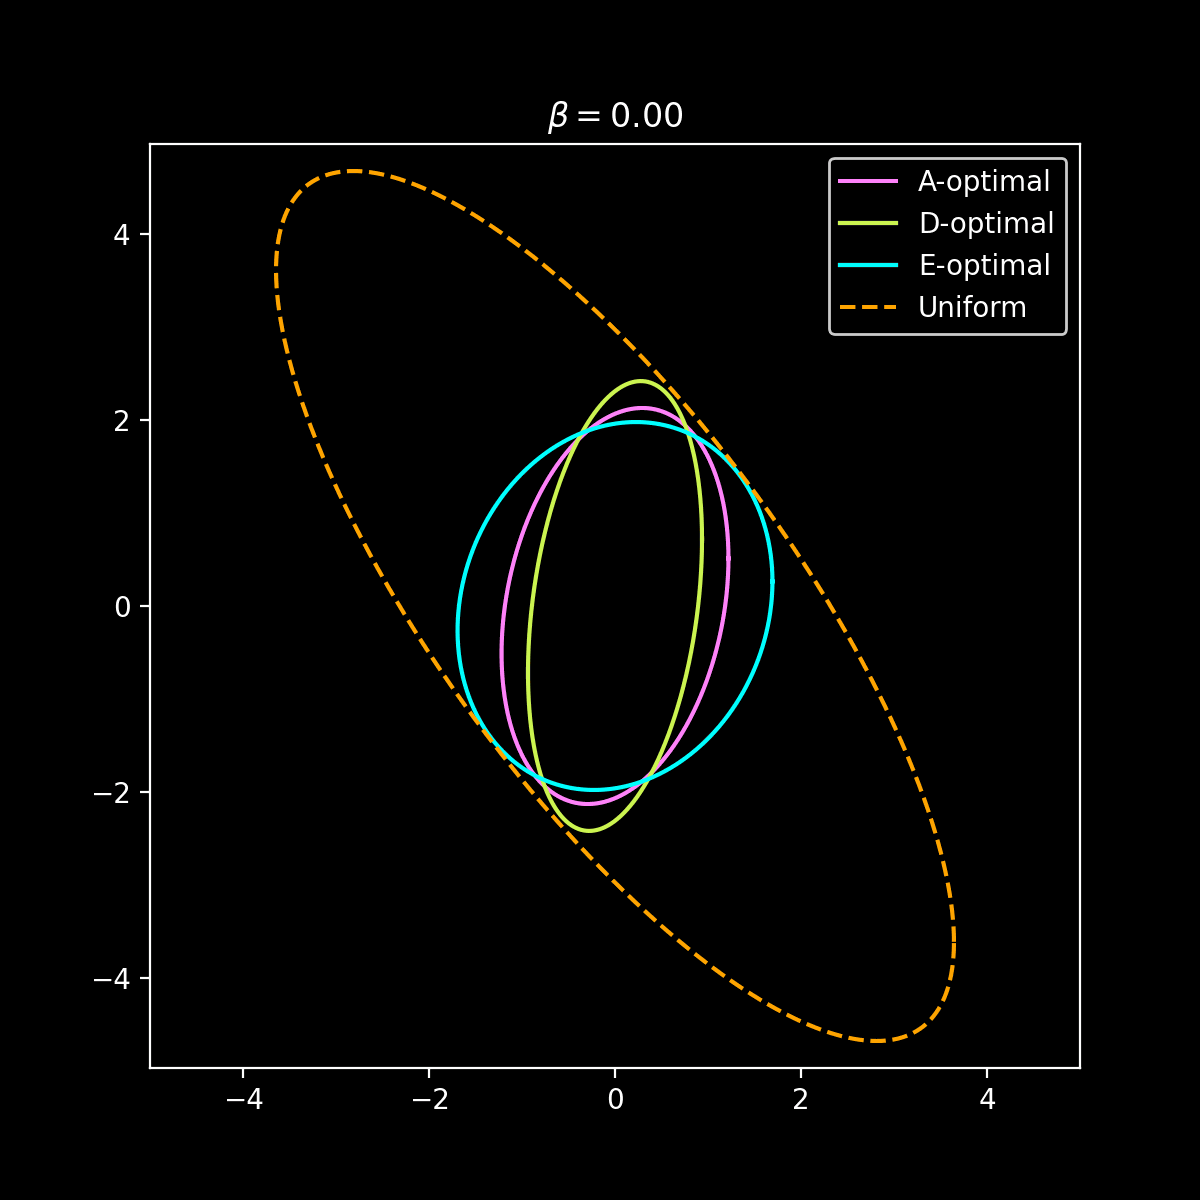

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import imageio
import os

# Problem data
m = 10
angles1 = np.linspace(3*np.pi/4, np.pi, m)
angles2 = np.linspace(0, -np.pi/2, m)

# Sensor positions
V = np.hstack((3.0 * np.array([np.cos(angles1), np.sin(angles1)]), 
               1.5 * np.array([np.cos(angles2), np.sin(angles2)])))
p = V.shape[1]
n = 2
noangles = 5000

# Pre-selected points
pre_selected_indices = [0, 5, 19]  # indices of the pre-selected points

# Set the necessary properties for inverted colors
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['savefig.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['legend.facecolor'] = 'black'
plt.rcParams['legend.edgecolor'] = 'white'
plt.rcParams['legend.labelcolor'] = 'white'
plt.rcParams['legend.frameon'] = True
plt.rcParams['axes.titlecolor'] = 'white'

use_mosek = True
changing_uniform = False

def update_plot(slider_val, save_frame=False, frame_path=None, dpi=200):
    pre_selected_counts = [slider_val/3, slider_val/3, slider_val/3]  # corresponding fixed lambda values
    pre_selected_sum = sum(pre_selected_counts)

    ############################################
    # D-optimal design
    ############################################
    lambda_d = cp.Variable(p)
    objective = cp.Maximize(cp.log_det(V @ cp.diag(lambda_d) @ V.T))
    constraints = [cp.sum(lambda_d) == 1, lambda_d >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_d[idx] == pre_selected_counts[i])
    problem = cp.Problem(objective, constraints)
    if use_mosek:
        problem.solve(solver=cp.MOSEK)
    else:
        problem.solve(solver=cp.SCS)

    lambda_d_value = lambda_d.value

    ############################################
    # A-optimal design
    ############################################
    lambda_a = cp.Variable(p)
    u = cp.Variable(n)
    objective = cp.Minimize(cp.sum(u))
    constraints = []
    for k in range(n):
        M = cp.vstack([
            cp.hstack([V @ cp.diag(lambda_a) @ V.T, np.eye(n)[:, k:k+1]]),
            cp.hstack([np.eye(n)[k:k+1, :], cp.reshape(u[k], (1, 1))])
        ])
        constraints.append(M >> 0)
    constraints += [cp.sum(lambda_a) == 1, lambda_a >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_a[idx] == pre_selected_counts[i])

    problem = cp.Problem(objective, constraints)
    if use_mosek:
        problem.solve(solver=cp.MOSEK)
    else:
        problem.solve(solver=cp.SCS)

    lambda_a_value = lambda_a.value

    ############################################
    # E-optimal design
    ############################################
    t = cp.Variable()
    lambda_e = cp.Variable(p)
    objective = cp.Maximize(t)
    constraints = [V @ cp.diag(lambda_e) @ V.T >> t * np.eye(n)]
    constraints += [cp.sum(lambda_e) == 1, lambda_e >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_e[idx] == pre_selected_counts[i])

    problem = cp.Problem(objective, constraints)
    if use_mosek:
        problem.solve(solver=cp.MOSEK)
    else:
        problem.solve(solver=cp.SCS)

    lambda_e_value = lambda_e.value

    ############################################
    # B-optimal design
    ############################################
    lambda_b = cp.Variable(p)
    objective = cp.Maximize(cp.trace(V @ cp.diag(lambda_b) @ V.T))
    constraints = [cp.sum(lambda_b) == 1, lambda_b >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_b[idx] == pre_selected_counts[i])

    problem = cp.Problem(objective, constraints)
    if use_mosek:
        problem.solve(solver=cp.MOSEK)
    else:
        problem.solve(solver=cp.ECOS)

    lambda_b_value = lambda_b.value

    # Confidence ellipsoids for all designs
    eta = 6.2514  # chi2inv(.9,3)
    angles = np.linspace(0, 2 * np.pi, noangles)
    plt.figure(figsize=(6, 6), dpi=dpi)  # Set DPI here for higher resolution

    # A-optimal ellipsoid
    W = V @ np.diag(lambda_a_value) @ V.T
    R = np.linalg.cholesky(W)
    ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='A-optimal', color="#FF83FA")

    # B-optimal ellipsoid
    W = V @ np.diag(lambda_b_value) @ V.T
    # check if W is positive definite
    if np.all(np.linalg.eigvals(W) >= 0):
        R = np.linalg.cholesky(W)
        ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
        plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='B-optimal', color="white")

    # D-optimal ellipsoid
    W = V @ np.diag(lambda_d_value) @ V.T
    R = np.linalg.cholesky(W)
    ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='D-optimal', color="#ccf551")

    # E-optimal ellipsoid
    W = V @ np.diag(lambda_e_value) @ V.T
    R = np.linalg.cholesky(W)
    ellipsoid = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid[0, :], ellipsoid[1, :], label='E-optimal', color="#00FFFF")


    # Uniform design ellipsoid
    if changing_uniform:
        lambda_uniform_value = 1 - slider_val
        lambda_uniform_value = (lambda_uniform_value / (p-3)) * np.ones(p)
        lambda_uniform_value[pre_selected_indices] = pre_selected_counts
        W_u = V @ np.diag(lambda_uniform_value) @ V.T#np.linalg.inv(V @ V.T / p)
        R = np.linalg.cholesky(W_u)
    else:
        W_u = np.linalg.inv(V @ V.T / p)
        R = np.linalg.cholesky(W_u)
    ellipsoid_u = np.sqrt(eta) * np.linalg.solve(R, np.array([np.cos(angles), np.sin(angles)]))
    plt.plot(ellipsoid_u[0, :], ellipsoid_u[1, :], '--', label='Uniform', color="orange")

    # plt.scatter(0, 0, color='white', marker='+')
    # plt.axis('equal')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.legend()
    plt.title(rf'$\beta = {slider_val:.2f}$')
    # set xlim and ylim to avoid autoscaling

    
    if save_frame and frame_path:
        plt.savefig(frame_path, dpi=dpi)  # Set DPI here for saving higher resolution images
    plt.close()

# Create a directory to save frames
os.makedirs('frames', exist_ok=True)

# Generate frames
for i, val in enumerate(np.linspace(0, 1, 101)):
    frame_path = f'frames/frame_{i:03d}.png'
    update_plot(val, save_frame=True, frame_path=frame_path, dpi=200)  # Set DPI here for higher resolution

# Create a GIF
with imageio.get_writer('evolution.gif', mode='I', duration=0.1) as writer:
    for i in range(101):
        frame_path = f'frames/frame_{i:03d}.png'
        image = imageio.imread(frame_path)
        writer.append_data(image)

# Clean up frames directory
import shutil
shutil.rmtree('frames')

# Display the GIF
from IPython.display import Image
Image(filename='evolution.gif')


/var/folders/gq/j5vwgp6n61vgbjxq5yr427w40000gn/T/ipykernel_12830/1796575283.py:169: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


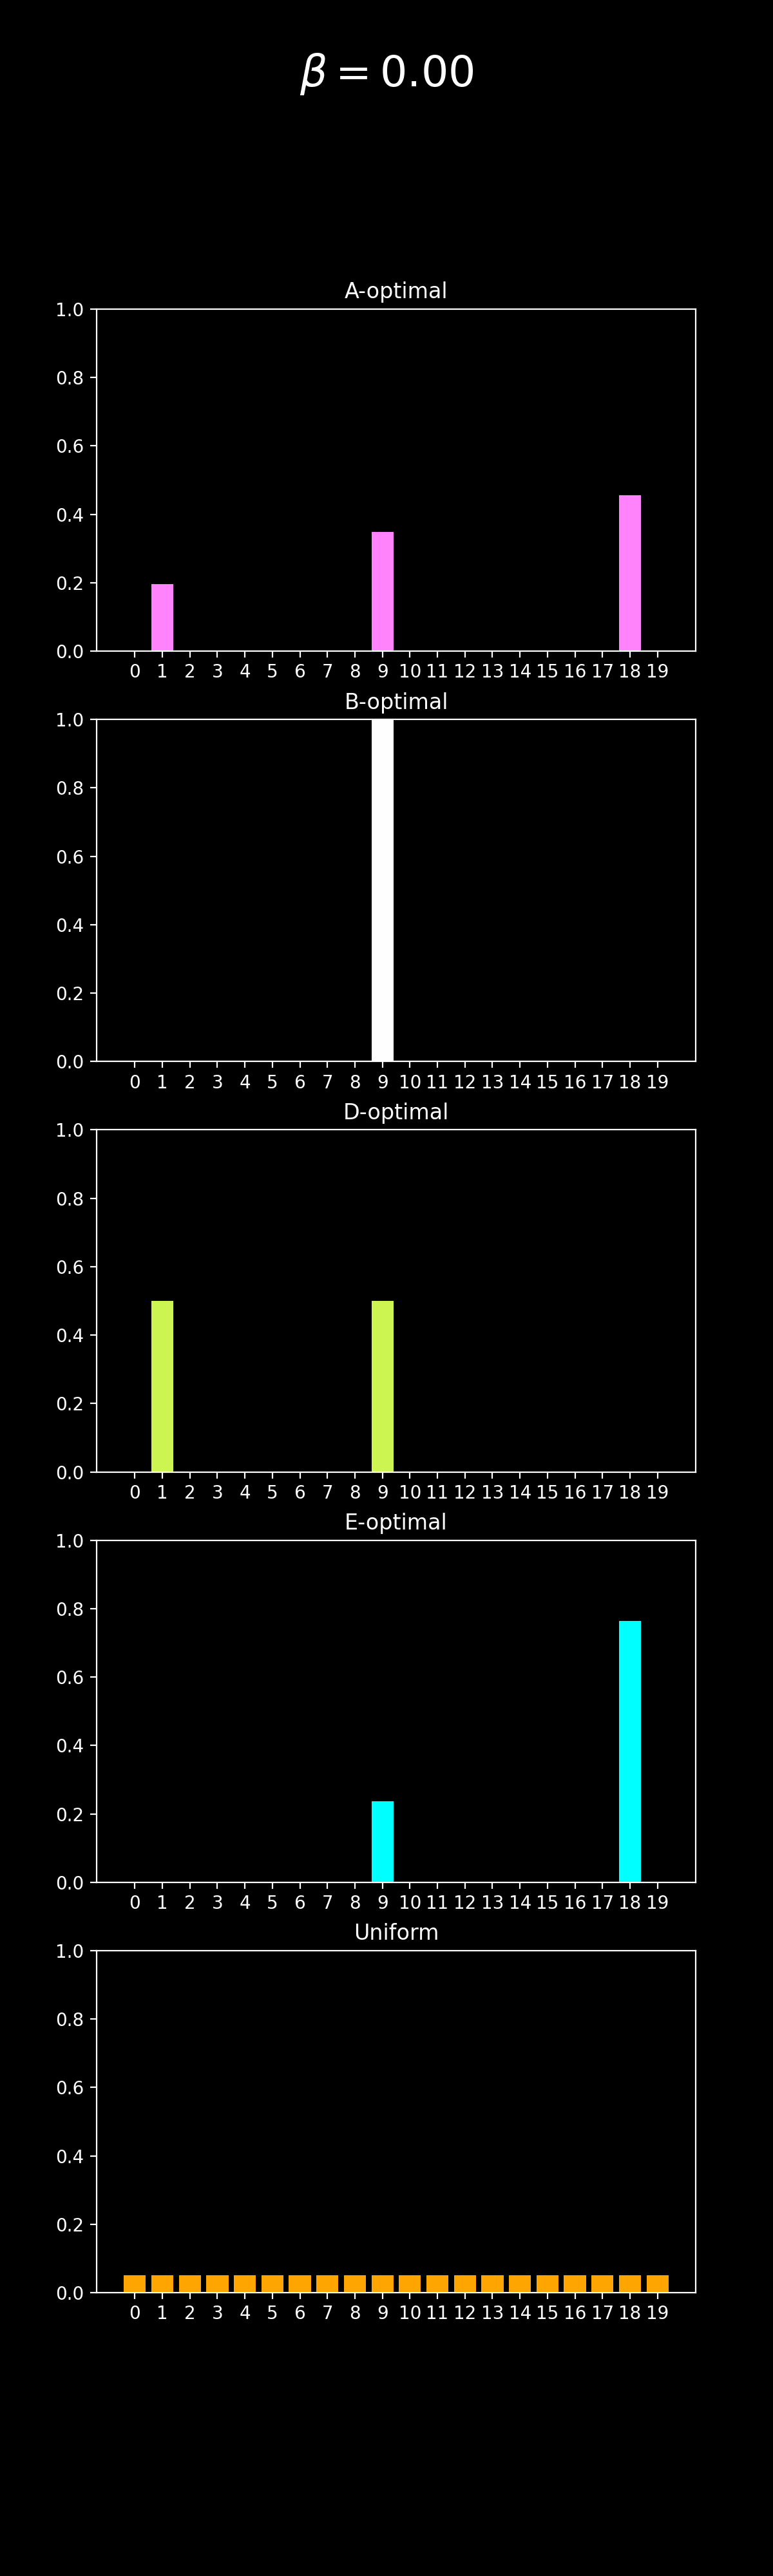

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import imageio
import os

# Problem data
m = 10
angles1 = np.linspace(3*np.pi/4, np.pi, m)
angles2 = np.linspace(0, -np.pi/2, m)

# Sensor positions
V = np.hstack((3.0 * np.array([np.cos(angles1), np.sin(angles1)]), 
               1.5 * np.array([np.cos(angles2), np.sin(angles2)])))
p = V.shape[1]
n = 2
noangles = 5000

# Pre-selected points
pre_selected_indices = [0, 5, 19]  # indices of the pre-selected points

# Set the necessary properties for inverted colors
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['savefig.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['legend.facecolor'] = 'black'
plt.rcParams['legend.edgecolor'] = 'white'
plt.rcParams['legend.labelcolor'] = 'white'
plt.rcParams['legend.frameon'] = True
plt.rcParams['axes.titlecolor'] = 'white'

use_mosek = True
changing_uniform = False

def update_plot(slider_val, save_frame=False, frame_path=None, dpi=200):
    pre_selected_counts = [slider_val/3, slider_val/3, slider_val/3]  # corresponding fixed lambda values
    pre_selected_sum = sum(pre_selected_counts)

    ############################################
    # D-optimal design
    ############################################
    lambda_d = cp.Variable(p)
    objective = cp.Maximize(cp.log_det(V @ cp.diag(lambda_d) @ V.T))
    constraints = [cp.sum(lambda_d) == 1, lambda_d >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_d[idx] == pre_selected_counts[i])
    problem = cp.Problem(objective, constraints)
    if use_mosek:
        problem.solve(solver=cp.MOSEK)
    else:
        problem.solve(solver=cp.SCS)

    lambda_d_value = lambda_d.value

    ############################################
    # A-optimal design
    ############################################
    lambda_a = cp.Variable(p)
    u = cp.Variable(n)
    objective = cp.Minimize(cp.sum(u))
    constraints = []
    for k in range(n):
        M = cp.vstack([
            cp.hstack([V @ cp.diag(lambda_a) @ V.T, np.eye(n)[:, k:k+1]]),
            cp.hstack([np.eye(n)[k:k+1, :], cp.reshape(u[k], (1, 1))])
        ])
        constraints.append(M >> 0)
    constraints += [cp.sum(lambda_a) == 1, lambda_a >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_a[idx] == pre_selected_counts[i])

    problem = cp.Problem(objective, constraints)
    if use_mosek:
        problem.solve(solver=cp.MOSEK)
    else:
        problem.solve(solver=cp.SCS)

    lambda_a_value = lambda_a.value

    ############################################
    # E-optimal design
    ############################################
    t = cp.Variable()
    lambda_e = cp.Variable(p)
    objective = cp.Maximize(t)
    constraints = [V @ cp.diag(lambda_e) @ V.T >> t * np.eye(n)]
    constraints += [cp.sum(lambda_e) == 1, lambda_e >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_e[idx] == pre_selected_counts[i])

    problem = cp.Problem(objective, constraints)
    if use_mosek:
        problem.solve(solver=cp.MOSEK)
    else:
        problem.solve(solver=cp.SCS)

    lambda_e_value = lambda_e.value

    ############################################
    # B-optimal design
    ############################################
    lambda_b = cp.Variable(p)
    objective = cp.Maximize(cp.trace(V @ cp.diag(lambda_b) @ V.T))
    constraints = [cp.sum(lambda_b) == 1, lambda_b >= 0]
    for i, idx in enumerate(pre_selected_indices):
        constraints.append(lambda_b[idx] == pre_selected_counts[i])

    problem = cp.Problem(objective, constraints)
    if use_mosek:
        problem.solve(solver=cp.MOSEK)
    else:
        problem.solve(solver=cp.ECOS)

    lambda_b_value = lambda_b.value

    ############################################
    # Uniform design
    ############################################
    if changing_uniform:
        lambda_uniform_value = 1 - slider_val
        lambda_uniform_value = (lambda_uniform_value / (p-3)) * np.ones(p)
        lambda_uniform_value[pre_selected_indices] = pre_selected_counts
    else:
        lambda_uniform_value = np.ones(p) / p

    fig, ax = plt.subplots(5, 1, figsize=(6, 20), dpi=dpi)  # Set DPI here for higher resolution

    designs = [
        ('A-optimal', lambda_a_value, "#FF83FA", 0),
        ('B-optimal', lambda_b_value, "white", 1),
        ('D-optimal', lambda_d_value, "#ccf551", 2),
        ('E-optimal', lambda_e_value, "#00FFFF", 3),
        ('Uniform', lambda_uniform_value, "orange", 4)
    ]

    for label, lambda_value, color, subplot_index in designs:
        ax[subplot_index].bar(range(p), lambda_value, color=color)
        ax[subplot_index].set_title(label)
        ax[subplot_index].set_ylim([0, 1])
        ax[subplot_index].set_facecolor('black')
        ax[subplot_index].tick_params(axis='x', colors='white')
        ax[subplot_index].tick_params(axis='y', colors='white')
        # set bar ticks to be only integers 
        ax[subplot_index].set_xticks(range(p))
    
    plt.suptitle(rf'$\beta = {slider_val:.2f}$', color='white', fontsize=24)

    if save_frame and frame_path:
        plt.savefig(frame_path, dpi=dpi)  # Set DPI here for saving higher resolution images
    plt.close()

# Create a directory to save frames
os.makedirs('frames', exist_ok=True)

# Generate frames
for i, val in enumerate(np.linspace(0, 1, 101)):
    frame_path = f'frames/frame_{i:03d}.png'
    update_plot(val, save_frame=True, frame_path=frame_path, dpi=200)  # Set DPI here for higher resolution

# Create a GIF
with imageio.get_writer('evolution_histograms.gif', mode='I', duration=0.1) as writer:
    for i in range(101):
        frame_path = f'frames/frame_{i:03d}.png'
        image = imageio.imread(frame_path)
        writer.append_data(image)

# Clean up frames directory
import shutil
shutil.rmtree('frames')

# Display the GIF
from IPython.display import Image
Image(filename='evolution_histograms.gif')
